In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install tensorflow opencv-python matplotlib

In [ ]:
pip install pydicom Pillow joblib opencv-python

In [ ]:
#!pip list

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import shutil
import pydicom
import pydicom.data
import cv2
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
import hashlib

In [7]:
# Directories
train_labels_path = "train.csv"
train_series_description_path = "train_series_descriptions.csv"
train_labels_coordinates = "train_label_coordinates.csv"

dicom_dir = "dicom_images"
output_dir_png = "png_images"


# Process Raw Data
Import the new images, organize them and include them into the data that is being used.
- First we organize the data in the dataset, so it can be iterated by the algorithm later in the code

In [ ]:
df_series_description = pd.read_csv(train_series_description_path)
df_train_labels = pd.read_csv(train_labels_path)

print(df_series_description.shape)
df_series_description.tail()
#The type of data in study id is integer

(6294, 3)


,study_id,series_id,series_description
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2
6293,4290709089,4237840455,Sagittal T1


In [ ]:
# Coordinates of the trained labels

train_coordinates = pd.read_csv(train_labels_coordinates)
print(train_coordinates.shape)
df_coords = train_coordinates
train_coordinates.head(n=10)

(48692, 7)


,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
5,4003253,1054713880,4,Right Neural Foraminal Narrowing,L4/L5,187.961759,251.839388
6,4003253,1054713880,4,Right Neural Foraminal Narrowing,L5/S1,198.240918,285.613767
7,4003253,1054713880,5,Right Neural Foraminal Narrowing,L3/L4,187.227533,210.722753
8,4003253,1054713880,6,Right Neural Foraminal Narrowing,L1/L2,194.569790,127.755258
9,4003253,1054713880,6,Right Neural Foraminal Narrowing,L2/L3,191.632887,165.934990


In [ ]:
development_dataset = pd.merge(df_series_description, df_train_labels, on="study_id")
print(development_dataset.shape)
development_dataset.head(n=10)

(6294, 28)


,study_id,series_id,series_description,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,702807833,Sagittal T2/STIR,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4003253,1054713880,Sagittal T1,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
2,4003253,2448190387,Axial T2,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,4646740,3201256954,Axial T2,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
4,4646740,3486248476,Sagittal T1,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
5,4646740,3666319702,Sagittal T2/STIR,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
6,7143189,132939515,Sagittal T2/STIR,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
7,7143189,1951927562,Axial T2,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
8,7143189,3219733239,Sagittal T1,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
9,8785691,481125819,Sagittal T2/STIR,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild


In [ ]:
# Define a mapping for the categorical labels to numerical labels
mapping = {'Normal/Mild': 1, 'Moderate': 2, 'Severe': 3}

# Replace all occurrences in the dataset
development_dataset.replace(mapping, inplace=True)

# Choose only the images from the Axial type of MRIs for the Axial model
# Filter the data to include only axial images
df_summary = development_dataset[development_dataset['series_description'].str.contains("Axial", case=False)]

print(df_summary.shape)
df_summary.head()

(2340, 28)


<ipython-input-38-0c312a734864>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  development_dataset.replace(mapping, inplace=True)


,study_id,series_id,series_description,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
2,4003253,2448190387,Axial T2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4646740,3201256954,Axial T2,1.0,1.0,2.0,3.0,1.0,1.0,1.0,...,1.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0
7,7143189,1951927562,Axial T2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
11,8785691,2406919186,Axial T2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12,10728036,142859125,Axial T2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0


In [ ]:
print("Columns in df_summary:")
print(df_summary.columns.tolist())

Columns in df_summary:
['study_id', 'series_id', 'series_description', 'spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4', 'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1', 'left_neural_foraminal_narrowing_l1_l2', 'left_neural_foraminal_narrowing_l2_l3', 'left_neural_foraminal_narrowing_l3_l4', 'left_neural_foraminal_narrowing_l4_l5', 'left_neural_foraminal_narrowing_l5_s1', 'right_neural_foraminal_narrowing_l1_l2', 'right_neural_foraminal_narrowing_l2_l3', 'right_neural_foraminal_narrowing_l3_l4', 'right_neural_foraminal_narrowing_l4_l5', 'right_neural_foraminal_narrowing_l5_s1', 'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3', 'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5', 'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2', 'right_subarticular_stenosis_l2_l3', 'right_subarticular_stenosis_l3_l4', 'right_subarticular_stenosis_l4_l5', 'right_subarticular_stenosis_l5

## Create a dataset that will be passed into the model with the pictures

In [ ]:
# Get a list of all files in the folder
file_list = os.listdir(dicom_dir)
img_path = random.choice(file_list)
dcm_data = pydicom.dcmread(dicom_dir + "/" + img_path, force=True)
print(dcm_data.SeriesInstanceUID)
dcm_data

273701476.2647412037


Dataset.file_meta -------------------------------
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 273701476.1.5
(0002,0010) Transfer Syntax UID                 UI: RLE Lossless
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
-------------------------------------------------
(0008,0018) SOP Instance UID                    UI: 273701476.1.5
(0008,0023) Content Date                        DA: '20240503'
(0008,0033) Content Time                        TM: '223719.967337'
(0008,103E) Series Description                  LO: ''
(0010,0020) Patient ID                          LO: '273701476'
(0018,0050) Slice Thickness                     DS: '4'
(0018,0088) Spacing Between Slices              DS: '4.4'
(0018,5100) Patient Position                    CS: 'HFS'
(

Calculate the location of the MRI's based on their slice location, and iterating through a big sample of dcm files

* Due to the high volume of data, we take a sample of 500 rows to calculate from not on.

In [ ]:
import numpy as np
from tqdm import tqdm

# Parameters
num_files_to_process = 5000
sample_size = 5000  # Number of rows to sample for slice_df
spinal_levels = ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']

# Gather slice locations
slice_locations = []
all_dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
random_files = random.sample(all_dicom_files, min(num_files_to_process, len(all_dicom_files)))

for f in tqdm(random_files, desc="Gathering Slice Locations"):
    try:
        dcm = pydicom.dcmread(os.path.join(dicom_dir, f))
        if 'SliceLocation' in dcm:
            slice_locations.append((f, float(dcm.SliceLocation), dcm.InstanceNumber))
    except Exception as e:
        print(f"Error reading file {f}: {e}")

# Convert to DataFrame
slice_df = pd.DataFrame(slice_locations, columns=['filename', 'slice_location', 'instance_number'])

# Sample 500 rows from slice_df
slice_df = slice_df.sample(n=sample_size, random_state=1)
print("Sampled slice_df created with 500 rows.")


Gathering Slice Locations: 100%|██████████| 5000/5000 [10:53<00:00,  7.66it/s]

Sampled slice_df created with 500 rows.


In [ ]:
slice_df.shape

(5000, 3)

In [ ]:
slice_df.tail()

,filename,slice_location,instance_number
2895,29931867_1152175603_1.dcm,-30.948296,1
2763,322285839_3217130524_9.dcm,2.920085,9
905,434221231_3697211146_2.dcm,38.123177,2
3980,191717032_2854475493_17.dcm,-37.322600,17
235,286903519_226555729_20.dcm,-499.158000,20


We keep the KMeans from the full dataset, since that would give us better classification on the unlabaled data

In [ ]:
from sklearn.cluster import KMeans

# Clustering with KMeans for 5 clusters
slice_locations_array = slice_df['slice_location'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(slice_locations_array)

# Sort cluster centers by slice location to align with spinal levels
cluster_centers = sorted(kmeans.cluster_centers_.flatten())
slice_df['level'] = slice_df['slice_location'].apply(
    lambda loc: spinal_levels[np.argmin([abs(loc - center) for center in cluster_centers])]
)
slice_df['cluster'] = kmeans.predict(slice_locations_array)


In [ ]:
# Verify assignment
print(slice_df[['filename', 'slice_location', 'instance_number', 'level']].head())

                         filename  slice_location  instance_number  level
2764   90711686_1614973506_13.dcm        0.000000               13  L4/L5
4767   215111925_1633670525_7.dcm       -4.892174                7  L4/L5
3814    228290246_979977423_5.dcm      -29.940802                5  L3/L4
3499   87937369_2405188639_26.dcm      116.831276               26  L5/S1
2735  375877945_2673164833_28.dcm       23.880328               28  L4/L5


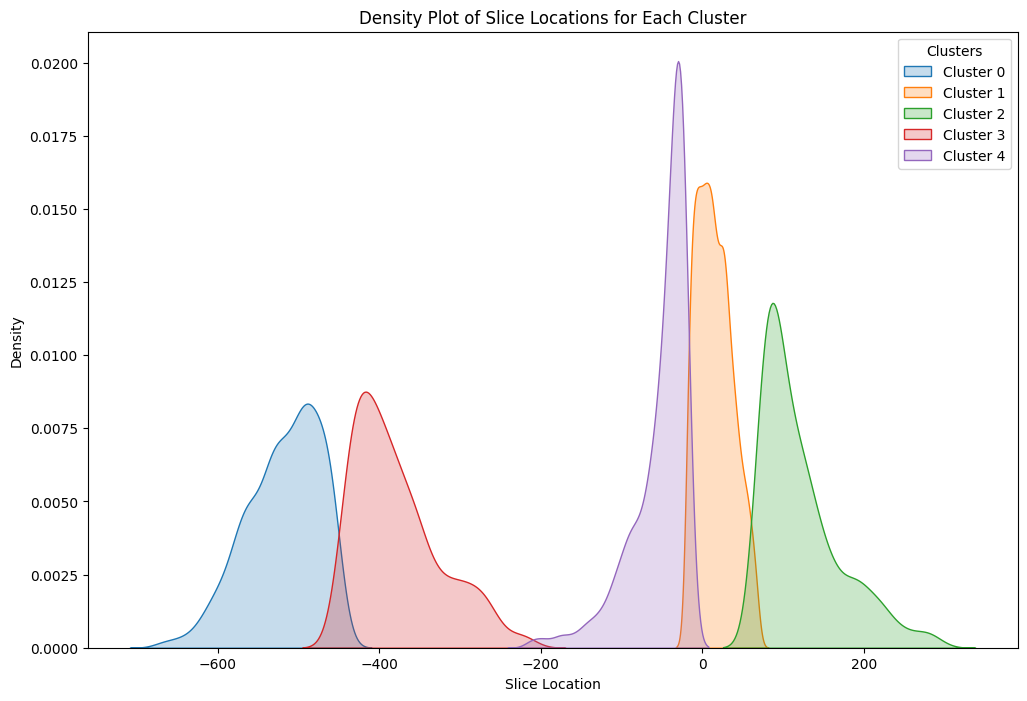

<ipython-input-46-c1b8a0718355>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=slice_df, x='cluster', y='slice_location', palette="Set3")


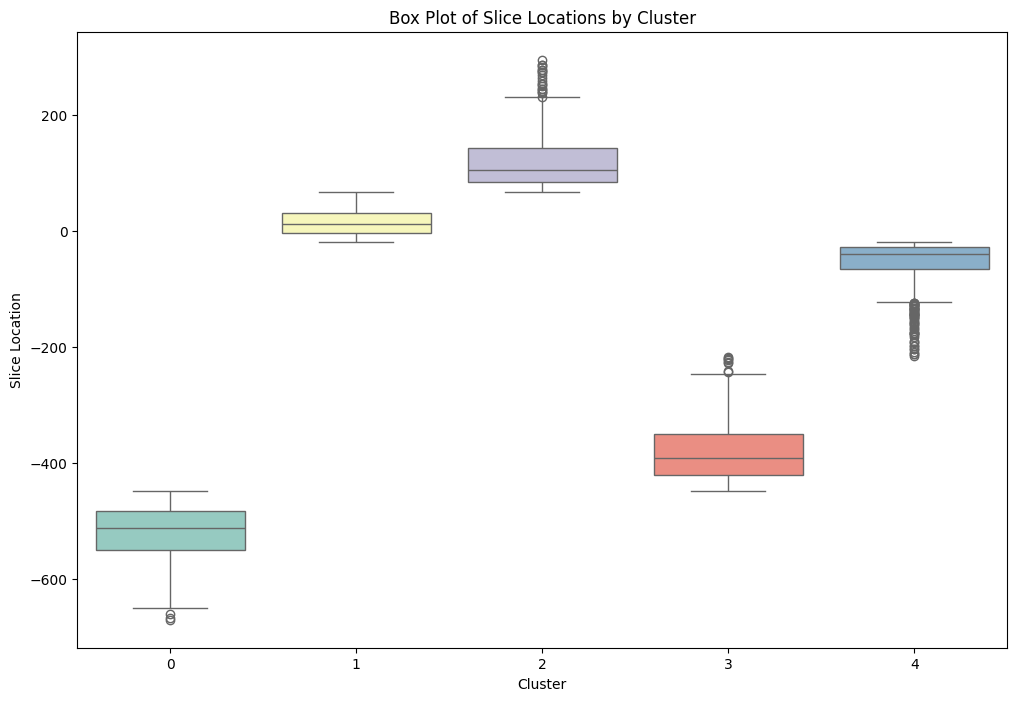

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Density plot of slice locations by cluster
plt.figure(figsize=(12, 8))
for cluster in range(5):
    cluster_data = slice_df[slice_df['cluster'] == cluster]
    if not cluster_data.empty:  # Check if there's data in this cluster
        sns.kdeplot(cluster_data['slice_location'], label=f'Cluster {cluster}', fill=True)

# Adding labels and title
plt.xlabel("Slice Location")
plt.title("Density Plot of Slice Locations for Each Cluster")
plt.legend(title="Clusters")
plt.show()

# Box plot of slice locations by cluster
plt.figure(figsize=(12, 8))
sns.boxplot(data=slice_df, x='cluster', y='slice_location', palette="Set3")
plt.xlabel('Cluster')
plt.ylabel('Slice Location')
plt.title('Box Plot of Slice Locations by Cluster')
plt.show()


In [ ]:
import joblib

# Save the KMeans model to an .h5 file using joblib
joblib.dump(kmeans, '/content/drive/MyDrive/Colab Notebooks/Senior Project/rsna-2024-lumbar-spine-degenerative-classification/kmeans_model.joblib')
print("Model saved as 'kmeans_model.joblib'")

# Save the slice data
slice_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Senior Project/rsna-2024-lumbar-spine-degenerative-classification/slice_data.csv', index=False)
print("Slice data saved as 'slice_data.csv'")


Model saved as 'kmeans_model.joblib'
Slice data saved as 'slice_data.csv'


In [11]:
import joblib
import pandas as pd

# Load the KMeans model
kmeans = joblib.load('G:/Mi unidad/Colab Notebooks/Senior Project/rsna-2024-lumbar-spine-degenerative-classification/kmeans_model.joblib')  # Use .joblib if that’s the format used to save the model
print("Model loaded from 'kmeans_model.joblib'")

# Load the slice data
slice_df = pd.read_csv('G:/Mi unidad/Colab Notebooks/Senior Project/rsna-2024-lumbar-spine-degenerative-classification/slice_data.csv')
print("Model and slice data loaded.")

C:\Users\guill\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 1.5.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model loaded from 'kmeans_model.joblib'
Model and slice data loaded.


In [12]:
slice_df.head()

,filename,slice_location,instance_number,level,cluster
0,90711686_1614973506_13.dcm,0.000000,13,L4/L5,1
1,215111925_1633670525_7.dcm,-4.892174,7,L4/L5,1
2,228290246_979977423_5.dcm,-29.940802,5,L3/L4,4
3,87937369_2405188639_26.dcm,116.831276,26,L5/S1,2
4,375877945_2673164833_28.dcm,23.880328,28,L4/L5,1


In [ ]:
slice_df['level'].value_counts()

slice_df['filename'] = slice_df['filename'].str.replace('.dcm', '', regex=False)
# Split 'filename' to create 'study_id', 'series_id', and 'instance' columns
slice_df[['study_id', 'series_id']] = slice_df['filename'].str.split('_', n=2, expand=True)[[0, 1]]
# Convert 'study_id' and 'series_id' to integer types for consistency
slice_df['study_id'] = slice_df['study_id'].astype(int)
slice_df['series_id'] = slice_df['series_id'].astype(int)

level = slice_df['level'].str.replace('/', '_').str.lower()

# Convert the sets to lists to enable indexing.
filename = list(slice_df['filename'])
study_id_list = list(slice_df['study_id'])
slice_locations = list(slice_df['slice_location'])
series_id_list = list(slice_df['series_id'])
instance_list = list(slice_df['instance_number'].astype(str)) # Convert to strings
level_list = list(slice_df['level'].str.replace('/', '_').str.lower()) # Convert to strings


print("df_summary columns:", df_summary.columns)


# Access the first element of the lists
print("File name:", filename[0],
      "\nSlice location:", slice_locations[0],
      "\nStudy ID:", study_id_list[0],
      "\nSeries ID:", series_id_list[0],
      "\nInstance:", instance_list[0],
      "\nLevel:", level_list[0])
print(slice_df.columns)

Code to check what is the structure of the data prior to fixing together both of the datasets

In [ ]:
# Ensure data types are consistent between slice_df and df_summary
slice_df['study_id'] = slice_df['study_id'].astype(int)
slice_df['series_id'] = slice_df['series_id'].astype(int)
df_summary['study_id'] = df_summary['study_id'].astype(int)
df_summary['series_id'] = df_summary['series_id'].astype(int)

# Enhanced safe_get function with detailed debug output
def safe_get(df, study_id, series_id, level, condition, default=np.nan):
    column_name = f"{condition}_{level}"  # Column name based on level and condition
    if column_name in df.columns:
        result = df.loc[
            (df['study_id'] == study_id) & (df['series_id'] == series_id),
            column_name
        ]
        # Detailed debug prints
        print(f"Searching for: {column_name} in df_summary with study_id={study_id} and series_id={series_id}")
        print("Match found:", not result.empty, "Result:", result.values if not result.empty else "No match")
        return result.values[0] if not result.empty else default
    print(f"Column {column_name} not found in df_summary")
    return default

# Testing each entry in slice_df
for _, row in slice_df.iterrows():
    study_id = row['study_id']
    series_id = row['series_id']
    instance_number = row['instance_number']
    level = row['level']

    # Test each grade retrieval with enhanced safe_get debug output
    spinal_canal_stenosis_grade = safe_get(df_summary, study_id, series_id, level, 'spinal_canal_stenosis')
    left_neural_foraminal_narrowing_grade = safe_get(df_summary, study_id, series_id, level, 'left_neural_foraminal_narrowing')
    right_neural_foraminal_narrowing_grade = safe_get(df_summary, study_id, series_id, level, 'right_neural_foraminal_narrowing')
    left_subarticular_stenosis_grade = safe_get(df_summary, study_id, series_id, level, 'left_subarticular_stenosis')
    right_subarticular_stenosis_grade = safe_get(df_summary, study_id, series_id, level, 'right_subarticular_stenosis')


In [ ]:
import pandas as pd
import numpy as np

# Assuming slice_df and df_summary are already loaded with the specified structure

# Define columns for final_df
columns_names = [
    "study_id",
    "series_id",
    "instance_number",
    "level",
    "spinal_canal_stenosis_grade",
    "left_neural_foraminal_narrowing",
    "right_neural_foraminal_narrowing",
    "left_subarticular_stenosis",
    "right_subarticular_stenosis"
]

final_df = pd.DataFrame(columns=columns_names)

# Standardize `level` naming in `slice_df` to match df_summary's format (e.g., "L1/L2" to "l1_l2")
slice_df['level'] = slice_df['level'].str.replace('/', '_').str.lower()

# Iterate through each row in `slice_df`
for _, row in slice_df.iterrows():
    study_id = row['study_id']
    series_id = row['series_id']
    instance_number = row['instance_number']
    level = row['level']

    # Create a helper function to retrieve values safely from `df_summary`
    def safe_get(df, study_id, series_id, level, condition, default=np.nan):
        column_name = f"{condition}_{level}"  # Target column based on level and condition
        if column_name in df.columns:
            result = df.loc[
                (df['study_id'] == study_id) & (df['series_id'] == series_id),
                column_name
            ]
            return result.values[0] if not result.empty else default
        return default

    # Retrieve grades for each condition
    spinal_canal_stenosis_grade = safe_get(df_summary, study_id, series_id, level, 'spinal_canal_stenosis')
    left_neural_foraminal_narrowing_grade = safe_get(df_summary, study_id, series_id, level, 'left_neural_foraminal_narrowing')
    right_neural_foraminal_narrowing_grade = safe_get(df_summary, study_id, series_id, level, 'right_neural_foraminal_narrowing')
    left_subarticular_stenosis_grade = safe_get(df_summary, study_id, series_id, level, 'left_subarticular_stenosis')
    right_subarticular_stenosis_grade = safe_get(df_summary, study_id, series_id, level, 'right_subarticular_stenosis')

    # Create a new row for final_df
    new_row = pd.DataFrame({
        "study_id": [study_id],
        "series_id": [series_id],
        "instance_number": [instance_number],
        "level": [level],
        "spinal_canal_stenosis_grade": [spinal_canal_stenosis_grade],
        "left_neural_foraminal_narrowing": [left_neural_foraminal_narrowing_grade],
        "right_neural_foraminal_narrowing": [right_neural_foraminal_narrowing_grade],
        "left_subarticular_stenosis": [left_subarticular_stenosis_grade],
        "right_subarticular_stenosis": [right_subarticular_stenosis_grade]
    })

    # Append the new row to final_df
    final_df = pd.concat([final_df, new_row], ignore_index=True)

# Display the first few rows of final_df to confirm
print(final_df.head())

# Save final dataset to CSV
output_path = '/content/drive/MyDrive/Colab Notebooks/Senior Project/rsna-2024-lumbar-spine-degenerative-classification/Final_MRI_Dataset.csv'
final_df.to_csv(output_path, index=False)
print(f"Final dataset saved to {output_path}")


<ipython-input-52-d298f2203895>:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, new_row], ignore_index=True)


    study_id   series_id instance_number  level  spinal_canal_stenosis_grade  \
0   90711686  1614973506              13  l4_l5                          1.0   
1  215111925  1633670525               7  l4_l5                          NaN   
2  228290246   979977423               5  l3_l4                          NaN   
3   87937369  2405188639              26  l5_s1                          1.0   
4  375877945  2673164833              28  l4_l5                          2.0   

   left_neural_foraminal_narrowing  right_neural_foraminal_narrowing  \
0                              1.0                               2.0   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              1.0                               1.0   
4                              2.0                               3.0   

   left_subarticular_stenosis  right_subarticular_stenosis  
0                        

In [ ]:
# Remove rows with NaN values in any of the specified grading columns
grading_columns = [
    "spinal_canal_stenosis_grade",
    "left_neural_foraminal_narrowing",
    "right_neural_foraminal_narrowing",
    "left_subarticular_stenosis",
    "right_subarticular_stenosis"
]

# Drop rows with NaN values in any of the grading columns
final_df_cleaned = final_df.dropna(subset=grading_columns)

# Display the cleaned DataFrame to confirm NaN rows are removed
print(final_df_cleaned.head())

# Save the cleaned dataset to CSV
output_path = '/content/drive/MyDrive/Colab Notebooks/Senior Project/rsna-2024-lumbar-spine-degenerative-classification/Final_MRI_Dataset_Cleaned.csv'
final_df_cleaned.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to {output_path}")


    study_id   series_id instance_number  level  spinal_canal_stenosis_grade  \
0   90711686  1614973506              13  l4_l5                          1.0   
3   87937369  2405188639              26  l5_s1                          1.0   
4  375877945  2673164833              28  l4_l5                          2.0   
5  389494496  4196685981              35  l3_l4                          1.0   
6  305152236  3401721603              19  l2_l3                          1.0   

   left_neural_foraminal_narrowing  right_neural_foraminal_narrowing  \
0                              1.0                               2.0   
3                              1.0                               1.0   
4                              2.0                               3.0   
5                              1.0                               1.0   
6                              1.0                               1.0   

   left_subarticular_stenosis  right_subarticular_stenosis  
0                        

# Organize images

As we have +2000 images, we will store them into 5 different folders, one for each of the conditions, so we can train the model on the different conditions. When we create the model, we will structure it to have 5 different outputs.

In [15]:
import os
import pydicom
import numpy as np
from PIL import Image

def convert_dicom_to_png_batch(dicom_folder, output_folder):
    """
    Converts all DICOM files in a folder to PNG and saves them in the specified output folder.

    Parameters:
    - dicom_folder (str): Path to the folder containing DICOM files.
    - output_folder (str): Path to the folder where PNG files will be saved.

    Returns:
    - None
    """
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through all files in the DICOM folder
    for dicom_file in os.listdir(dicom_folder):
        dicom_path = os.path.join(dicom_folder, dicom_file)

        # Ensure it's a DICOM file
        if dicom_file.lower().endswith(".dcm"):
            try:
                # Read the DICOM file
                dcm = pydicom.dcmread(dicom_path)
                img_array = dcm.pixel_array

                # Normalize pixel values to [0, 255] for PNG saving
                img_array = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array)) * 255
                img_array = img_array.astype(np.uint8)

                # Save as PNG
                png_filename = os.path.splitext(dicom_file)[0] + ".png"
                png_path = os.path.join(output_folder, png_filename)
                Image.fromarray(img_array).save(png_path)

                print(f"Converted: {dicom_file} -> {png_filename}")
            except Exception as e:
                print(f"Error converting {dicom_file}: {e}")

# Example usage
dicom_folder = "dicom_images" 
output_folder = "processed_images"  
convert_dicom_to_png_batch(dicom_folder, output_folder)

Converted: 74782131_3401861580_25.dcm -> 74782131_3401861580_25.png
